Initial imports of necessary packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import time
from sklearn.metrics import accuracy_score,  f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA, NMF
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support, log_loss
import random
import time
import collections
import warnings
from scipy.stats import pearsonr, spearmanr

%matplotlib inline

Read in Train, Test and Label csv files as Pandas dataframes

In [ ]:
train_tcga_df = pd.read_csv('../data/train_tcga_expression_matrix_processed.tsv', header=0, sep='\t')
test_tcga_df = pd.read_csv('../data/test_tcga_expression_matrix_processed.tsv', header=0, sep='\t')

labels_tcga_df = pd.read_csv('../data/tcga_sample_identifiers.tsv', header=0, sep='\t')

The final TCGA PanCanAtlas gene expression matrix with 11060 samples, which included 33 different cancer types, and 16148 genes.

With a 90/10 train/test split, this results in 9954/1106 train test sample split, with 16149 cols (1 added col for 'sample_id')

Load first 5 samples in each of the dataframes to obtain a feel for the structure of the data

In [ ]:
train_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,3430.0,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,6050.0,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,4930.0,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,3890.0,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,1930.0,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0


In [ ]:
test_tcga_df.head()

,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9987,9988,9989,999,9990,9991,9992,9993,9994,9997
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,2730.0,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,4510.0,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,4420.0,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,5460.0,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,5200.0,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0


In [ ]:
labels_tcga_df.head()

,sample_id,sample_type,cancer_type
0,TCGA-02-0047-01,Primary Solid Tumor,GBM
1,TCGA-02-0055-01,Primary Solid Tumor,GBM
2,TCGA-02-2483-01,Primary Solid Tumor,GBM
3,TCGA-02-2485-01,Primary Solid Tumor,GBM
4,TCGA-02-2486-01,Primary Solid Tumor,GBM


Print shape of each of the dfs

In [ ]:
print("Train df Shape", train_tcga_df.shape)
print("Test df Shape", test_tcga_df.shape)
print("Labels df Shape", labels_tcga_df.shape)

Train df Shape (9954, 16149)
Test df Shape (1106, 16149)
Labels df Shape (11060, 3)


Obtain the list of 'Sample ID' (Indicator Variable)  in each of the dataframes, and use them to append the cancer type (aka the Y variable) from the labels df onto the train and test df

In [ ]:
train_id = train_tcga_df['sample_id']
test_id = test_tcga_df['sample_id']
label_id = labels_tcga_df['sample_id']

In [ ]:
merge_train = []
merge_test = []

for i in train_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_train.append(str(val['cancer_type']).split()[1])
    
for i in test_id:
    val = labels_tcga_df.loc[labels_tcga_df['sample_id'] == i]
    merge_test.append(str(val['cancer_type']).split()[1])

Create new col in train and test with the cancer type added in

In [ ]:
train_tcga_df['cancer_type'] = merge_train
print(train_tcga_df.shape)
train_tcga_df.head()

(9954, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-LL-A73Z-01,202.0,28.5,329.0,84.5,492.0,448.0,4.590,14.70,337.0,...,717.0,1800.0,6360.0,299.0,2310.0,10.60,3190.0,337.0,892.0,BRCA
1,TCGA-55-8207-01,77.5,22.5,74.5,13.1,784.0,333.0,2.540,176.00,153.0,...,923.0,2490.0,11300.0,1150.0,4030.0,9.08,2890.0,316.0,301.0,LUAD
2,TCGA-FF-A7CR-01,152.0,0.0,3020.0,26.6,486.0,497.0,0.000,8.47,348.0,...,897.0,861.0,39.7,464.0,3320.0,0.00,1330.0,606.0,558.0,DLBC
3,TCGA-BK-A13C-11,80.5,40.0,70.6,284.0,2420.0,325.0,1.200,91.40,231.0,...,737.0,1410.0,10.9,1120.0,1990.0,5.24,3090.0,673.0,263.0,UCEC
4,TCGA-EB-A6L9-06,319.0,0.0,422.0,184.0,423.0,392.0,0.945,2.36,585.0,...,328.0,1340.0,7010.0,450.0,563.0,10.90,3780.0,37.3,1120.0,SKCM


In [ ]:
test_tcga_df['cancer_type'] = merge_test
print(test_tcga_df.shape)
test_tcga_df.head()

(1106, 16150)


,sample_id,1,10,100,1000,10000,10001,10002,10003,100037417,...,9988,9989,999,9990,9991,9992,9993,9994,9997,cancer_type
0,TCGA-CN-5365-01,70.5,0.000,1310.0,18.70,73.9,757.0,1.82,10.50,414.0,...,612.0,5780.0,10400.0,879.0,3830.0,4.10,4220.0,308.0,1300.0,HNSC
1,TCGA-LP-A7HU-01,27.8,0.949,517.0,6.17,63.6,365.0,4.27,9.02,633.0,...,543.0,1360.0,4960.0,510.0,2220.0,17.60,2410.0,233.0,993.0,CESC
2,TCGA-22-5491-11,87.6,3.760,88.3,14.40,642.0,295.0,6.84,59.90,159.0,...,479.0,2190.0,4480.0,870.0,2120.0,5.13,5030.0,285.0,530.0,LUSC
3,TCGA-CS-6667-01,75.8,0.000,55.6,2720.00,2170.0,281.0,3.90,9.57,251.0,...,1550.0,1370.0,12.8,1430.0,601.0,23.70,7530.0,473.0,258.0,LGG
4,TCGA-20-1684-01,63.1,0.703,75.2,4500.00,792.0,433.0,1.64,4.16,623.0,...,812.0,1070.0,8410.0,505.0,1170.0,14.80,1910.0,281.0,221.0,OV


To conserve RAM usage, we delete computed variables when are done using them. First we delete the labels matrix, as we have already appended cancer type to train and test matrices

In [ ]:
del labels_tcga_df

Function to Perform Logistic Regression, and return accuracy and runtime of classifier


In [ ]:
def runLR(df2, test2):

    #LR Classifier with 16148 feature dimensionality
    start_time = time.time()
    clf = LogisticRegression(random_state=0).fit(df2.iloc[:,:-1],df2["cancer_type"])
    pred = clf.predict(test2.iloc[:,:-1])
    LR_accuracy = accuracy_score(test2.cancer_type,pred)
    LR_computation_time = time.time() - start_time

    del clf

    return LR_accuracy, LR_computation_time

Function to Perform SVM Classification, and return accuracy and runtime of classifier


In [ ]:
def runSVM(df2, test2):

    start_time = time.time()
    clf = SVC(random_state=0).fit(df2.iloc[:,:-1],df2["cancer_type"])
    pred = clf.predict(test2.iloc[:,:-1])
    SVM_accuracy = accuracy_score(test2.cancer_type,pred)
    SVM_computation_time = time.time() - start_time

    del clf

    return SVM_accuracy, SVM_computation_time

Function to Perform K Means Clustering, and return accuracy and runtime of classifier


In [ ]:
def runKMeans(df2, test2):

    #LR Classifier with 16148 feature dimensionality
    start_time = time.time()
    clf = KMeans(n_clusters=33, random_state=0).fit(df2.iloc[:,:-1])
    pred = clf.predict(test2.iloc[:,:-1])
    KM_accuracy = accuracy_score(test2.cancer_type,pred)
    KM_computation_time = time.time() - start_time

    del clf

    return KM_accuracy, KM_computation_time

Function to Perform Gaussian Mixture Model Clustering, and return accuracy and runtime of classifier



In [ ]:
def runGMM(df2, test2):

    #LR Classifier with 16148 feature dimensionality
    start_time = time.time()
    clf = GaussianMixture(n_components=33, random_state=0, covariance_type='diag').fit(df2.iloc[:,:-1])
    pred = clf.predict(test2.iloc[:,:-1])
    GMM_accuracy = accuracy_score(test2.cancer_type,pred)
    GMM_computation_time = time.time() - start_time

    del clf

    return GMM_accuracy, GMM_computation_time

Function to recontruct original featureset from scores and loadings

In [ ]:
def compile_reconstruction(input_df,nmf_df,nmf,ctype,k,test=False):
        """
        Compile reconstruction costs between input and algorithm reconstruction
        Arguments:
        Two dictionaries storing 1) reconstruction costs and 2) reconstructed
        matrix for each algorithm
        nmf - model used for data reduction
        nmf_df - matrix in reduced component space
        input_df - original featureset, used for setting values of col names in pandas
        """
        
        
        
        nmf_reconstruct_mat = nmf.inverse_transform(nmf_df)
        
        reconstruct_mat = pd.DataFrame(nmf_reconstruct_mat,
                                              index=input_df.index,
                                              columns=input_df.columns)

        return reconstruct_mat


Function to Scale Data before performing NMF. This Function scales data around a Gaussian (Normal) distribution, before shifting the distribution to ensure non-negative entries

In [ ]:
def NMF_scale(df2,test2):
    '''
    df2 - train dataframe
    test2 - test dataframe
    '''

    #StandardScaler shifts data to follow Gaussian distribution
    standard_train = StandardScaler()
    result_train = standard_train.fit_transform(df2.iloc[:,:-1])
    result_train = pd.DataFrame(result_train)

    #MinMax shifts data to ensure no negative values
    scaler_train = MinMaxScaler()
    result_train=scaler_train.fit_transform(result_train.iloc[:,:-1])
    result_train = pd.DataFrame(result_train)
    

    #Repeat procedure for test dataframe
    standard_test = StandardScaler()
    result_test = standard_test.fit_transform(test2.iloc[:,:-1])
    result_test = pd.DataFrame(result_test)

    scaler_test = MinMaxScaler()
    result_test=scaler_test.fit_transform(result_test.iloc[:,:-1])
    result_test = pd.DataFrame(result_test)

    return result_train, result_test

Function to Scale Data before performing PCA/ICA. This Function scales data around a Gaussian (Normal) distribution.

In [ ]:
def PCA_scale(df2,test2):
    standard_train = StandardScaler()
    result_train = standard_train.fit_transform(df2.iloc[:,:-1])
    result_train = pd.DataFrame(result_train)

    #MinMax shifts data to ensure no negative values
    # result_train.to_csv ('/content/drive/MyDrive/BE275_Project/nmf/input_train_{}.csv'.format(ctype))
    
    standard_test = StandardScaler()
    result_test = standard_test.fit_transform(test2.iloc[:,:-1])
    result_test = pd.DataFrame(result_test)
    # result_test.to_csv ('/content/drive/MyDrive/BE275_Project/nmf/input_test_{}.csv'.format(ctype))

    return result_train, result_test

Compute NMF on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnNMF(result_train, result_test, ctype, k):

    '''
    result_train - scaled train dataframe
    result_test - scaled test dataframe
    ctype - cancertype we aim to detect
    k - no. of components
    '''
    
    start_time = time.time()
    

    #ensure n_comp does not exceed no. of features
    n_comp= min(k, result_train.shape[0])

    # Define NMF Model
    nmf = NMF(n_components=n_comp)
    
    # NMF Model Fitting for Train Set
    nmf_comp_train = nmf.fit_transform(result_train)
    colnames = ['nmf_{}'.format(x) for x in range(0, n_comp)]

    #Store NMF matrix and weights in csv
    nmf_comp_train = pd.DataFrame(nmf_comp_train,
                               columns=colnames,index=result_train.index)
    
    nmf_weights_train = pd.DataFrame(nmf.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    
    nmf_time = time.time()-start_time
    
    # NMF Transform on the Test Set
    nmf_comp_test = nmf.transform(result_test)
    nmf_comp_test = pd.DataFrame(nmf_comp_test,
                               columns=colnames,index=result_test.index)

    # compile reconstruction 
    reconstruct_mat_train = compile_reconstruction(result_train,nmf_comp_train ,nmf,ctype,k)
    reconstruct_mat_test = compile_reconstruction(result_test, nmf_comp_test, nmf,ctype,k)

    #Delete model to save RAM usage
    del nmf
    
    #return nmf scores from train and test, reconstruction from train and test, and computation time
    return reconstruct_mat_train, reconstruct_mat_test, nmf_comp_train, nmf_comp_test, nmf_time



Compute ICA on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnICA(result_train, result_test, k):
    # warnings.filterwarnings("ignore")
    
    start_time = time.time()
    

    #ensure n_comp does not exceed no. of features
    n_comp= min(k, result_train.shape[0])

    # Define ICA Model
    ica = FastICA(n_components=n_comp)
    
    # ICA Model Fitting for Train Set
    ica_comp_train = ica.fit_transform(result_train)
    colnames = ['ica_{}'.format(x) for x in range(0, n_comp)]

    #Store NMF matrix and weights in csv
    ica_comp_train = pd.DataFrame(ica_comp_train,
                               columns=colnames,index=result_train.index)
    ica_weights_train = pd.DataFrame(ica.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    ica_time = time.time()-start_time
    
    # NMF Transform on the Test Set
    ica_comp_test = ica.transform(result_test)
    ica_comp_test = pd.DataFrame(ica_comp_test,
                               columns=colnames,index=result_test.index)

    # compile reconstruction 
    reconstruct_mat_train = compile_reconstruction(result_train,ica_comp_train ,ica)
    reconstruct_mat_test = compile_reconstruction(result_test, ica_comp_test, ica)

    
    return reconstruct_mat_train, reconstruct_mat_test, ica_comp_train, ica_comp_test, ica_time



Compute PCA on Scaled Data, and return reconstructed matrices, scores and computation time

In [ ]:
def returnPCA(result_train, result_test, k):
    warnings.filterwarnings("ignore")

    start_time = time.time()
    
    n_comp= min(k, result_train.shape[0])

    # PCA calculation
    pca = PCA(n_components=n_comp)
    
    # PCA Model Fitting for Train Set
    principal_comp_train = pca.fit_transform(result_train)
    colnames = ['pca_{}'.format(x) for x in range(0, n_comp)]
    principal_comp_train = pd.DataFrame(principal_comp_train,
                               columns=colnames,index=result_train.index)
    pca_weights_train = pd.DataFrame(pca.components_,
                                        columns=result_train.columns,
                                        index=colnames)
    pca_time = time.time()-start_time
    
    # PCA Transform on the Test Set
    principal_comp_test = pca.transform(result_test)
    principal_comp_test = pd.DataFrame(principal_comp_test,
                               columns=colnames,index=result_test.index)

    
    # variance calculation
    explanation = pca.explained_variance_ratio_
    cummulative_sum = explanation.cumsum()
    
    # compile reconstruction 
    reconstruct_mat_train = compile_reconstruction(result_train,principal_comp_train ,pca)
    reconstruct_mat_test = compile_reconstruction(result_test, principal_comp_test, pca)

    del pca
    
    return reconstruct_mat_train, reconstruct_mat_test, principal_comp_train, principal_comp_test, pca_time

Function to separate last col (cancer type) as Y variable for prediction

In [ ]:
def prepNMFClassifier(df2, test2, nmf_comp_train, nmf_comp_test):
    '''
    df2 - train dataframe
    test2 - test dataframe
    nmf_comp_train - training scores matrix
    nmf_comp_test - test scores matrix
    '''

    #Detect last col from all input dataframes and matrices
    train_y= df2.cancer_type
    test_y=  test2.cancer_type
    
    train_x= nmf_comp_train.iloc[:,:-1]
    test_x = nmf_comp_test.iloc[:,:-1]
    
    return train_x,test_x,train_y,test_y

Function to perform Logistic Regression on scores and compute accuracy, precision, recall, F1 score and computation Time

In [ ]:


def NMFClassifier(train_x, train_y, test_x, test_y):
    '''
    train_x - nmf scores of training matrix
    test_x - nmf scores of test matrix
    train_y - ground truth Y values for training
    test_y - ground truth Y values for test
    '''
    
    start_time = time.time()

    #perform LR and predict test values
    clf2 = LogisticRegression(random_state=0).fit(train_x,train_y)
    pred= clf2.predict(test_x)

    #compute accuracy metrics
    accuracy = accuracy_score(pred,test_y)
    precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
    time_laps = time.time() - start_time

    #delete LR model to save RAM
    del clf2

    return accuracy, time_laps, precision[0], recall[0], f1score[0]

Function to perform K Means Clustering on scores and compute accuracy, precision, recall, F1 score and computation Time

In [ ]:


def NMF_KMeans_Classifier(train_x, train_y, test_x, test_y):
    
    start_time = time.time()
    clf2 = KMeans(n_clusters=33, random_state=0).fit(train_x)
    pred= clf2.predict(test_x)
    accuracy = accuracy_score(pred,test_y)
    precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
    time_laps = time.time() - start_time

    del clf2

    return accuracy, time_laps, precision[0], recall[0], f1score[0]

Function to perform GMM Clustering on scores and compute accuracy, precision, recall, F1 score and computation Time

In [ ]:


def NMF_GMM_Classifier(train_x, train_y, test_x, test_y):
    
    start_time = time.time()
    clf2 = GaussianMixture(n_components=33, random_state=0, covariance_type='diag').fit(train_x)
    pred= clf2.predict(test_x)
    accuracy = accuracy_score(pred,test_y)
    precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
    time_laps = time.time() - start_time

    del clf2

    return accuracy, time_laps, precision[0], recall[0], f1score[0]

Function to perform SVM Classification on scores and compute accuracy, precision, recall, F1 score and computation Time

In [ ]:


def NMF_SVM_Classifier(train_x, train_y, test_x, test_y):
    
    start_time = time.time()
    clf2 = SVC(random_state=0).fit(train_x,train_y)
    pred= clf2.predict(test_x)
    accuracy = accuracy_score(pred,test_y)
    precision, recall, f1score, _= precision_recall_fscore_support(test_y, pred)
    time_laps = time.time() - start_time

    del clf2

    return accuracy, time_laps, precision[0], recall[0], f1score[0]

Function to calculate reconstruction loss after NMF

In [ ]:


def calc_reconstruct_loss(input_df, reconstruct_mat): 
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after nmf
    '''
    
    loss = np.sum((input_df - reconstruct_mat) ** 2, axis=1).mean()
    
    return loss
    

Function to calculate pearson coefficient for each sample between the original and reconstructed matrices

In [ ]:
def calc_pearson(input_df, reconstruct_mat):
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after nmf
    '''   
    
    r = [pearsonr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]

    
    return r
    

Function to calculate spearman coefficient for each sample between the original and reconstructed matrices

In [ ]:
def calc_spearman(input_df, reconstruct_mat):
    '''
    input_df - original dataframe
    reconstruct_mat - reconstructed matrix after nmf
    '''
    s = [spearmanr(reconstruct_mat.iloc[x, :], input_df.iloc[x, :])[0] for x in range(input_df.shape[0])]

    return s
    

Function to return label encoded dataframe with 33 classes

In [ ]:
def multi_returnDf2(df, ind):
    '''
    df - input df to rename classes on (train_df or test_df)
    ind - either merge_trian or merge_test

    '''

    #drop sample_id (not needed as we have already appended the cancer type from labels)
    df2  = df.drop(['sample_id'], axis=1)

    le = LabelEncoder()
    df2['cancer_type'] = le.fit_transform(df2['cancer_type'])

    #Shuffle df2
    df2 = df2.sample(frac=1).reset_index(drop=True)

    return df2

Main Code for Comparison - Cell that first computes LR, SVM, KM, GMM for entire data. We then compute them for reduced dimensions from ICA, PCA and NMF as well

In [ ]:
#obtain all the different values of cancer types

c_type_list = collections.Counter(merge_train)

#Columns of resultant dataframe, and create it
cols = ['Full-data LR acc.', 'Full-data LR comp. time', 'Full-data SVM acc.', 'Full-data SVM comp. time',
        'Full-data K Means acc.', 'Full-data K Means comp. time', 'Full-data GMM acc.', 'Full-data GMM comp. time',
        'NMF LR calc. time', 'NMF SVM calc. time', 'NMF K Means calc. time', 'NMF GMM calc. time','NMF LR acc.','NMF LR Precision', 'NMF LR Recall', 'NMF LR F1Score', 'NMF SVM acc.',
        'NMF SVM Precision', 'NMF SVM Recall', 'NMF SVM F1Score','NMF K Means acc.','NMF K Means Precision', 'NMF K Means Recall', 'NMF K Means F1Score', 'NMF GMM acc.',
        'NMF GMM Precision', 'NMF GMM Recall', 'NMF GMM F1Score',
        'NMF Train Reconstruction Loss','NMF Test Reconstruction Loss',
        'PCA LR calc. time', 'PCA SVM calc. time','PCA K Means calc. time', 'PCA GMM calc. time','PCA LR acc.','PCA LR Precision', 'PCA LR Recall', 'PCA LR F1Score', 'PCA SVM acc.',
        'PCA SVM Precision', 'PCA SVM Recall', 'PCA SVM F1Score','PCA K Means acc.','PCA K Means Precision', 'PCA K Means Recall', 'PCA K Means F1Score', 'PCA GMM acc.',
        'PCA GMM Precision', 'PCA GMM Recall', 'PCA GMM F1Score',
        'PCA Train Reconstruction Loss','PCA Test Reconstruction Loss',
        'ICA LR calc. time', 'ICA SVM calc. time', 'ICA K Means calc. time', 'ICA GMM calc. time','ICA LR acc.','ICA LR Precision', 'ICA LR Recall', 'ICA LR F1Score', 'ICA SVM acc.',
        'ICA SVM Precision', 'ICA SVM Recall', 'ICA SVM F1Score','ICA K Means acc.','ICA K Means Precision', 'ICA K Means Recall', 'ICA K Means F1Score', 'ICA GMM acc.',
        'ICA GMM Precision', 'ICA GMM Recall', 'ICA GMM F1Score',
        'ICA Train Reconstruction Loss','ICA Test Reconstruction Loss'
       ]

results_comp = pd.DataFrame(columns = cols)
i = 0

#List of different values of k
num_latent_space= [2,5,10,20,50,100]


#Define empty lists to hold results in
loss_test_nmf_list=[]
loss_train_nmf_list=[]

loss_test_pca_list=[]
loss_train_pca_list=[]

loss_test_ica_list=[]
loss_train_ica_list=[]

time_nmf_svm_list = []
time_pca_svm_list = []
time_ica_svm_list = []

time_nmf_lr_list = []
time_pca_lr_list = []
time_ica_lr_list = []

time_nmf_km_list = []
time_pca_km_list = []
time_ica_km_list = []

time_nmf_gmm_list = []
time_pca_gmm_list = []
time_ica_gmm_list = []

accuracy_nmf_lr_list = []
accuracy_pca_lr_list = []
accuracy_ica_lr_list = []

accuracy_nmf_svm_list = []
accuracy_pca_svm_list = []
accuracy_ica_svm_list = []

accuracy_nmf_gmm_list = []
accuracy_pca_gmm_list = []
accuracy_ica_gmm_list = []

accuracy_nmf_km_list = []
accuracy_pca_km_list = []
accuracy_ica_km_list = []


#train data
df2 = multi_returnDf2(train_tcga_df, merge_train)
#test data
test2 = multi_returnDf2(test_tcga_df, merge_test)

# run Clasifier models on Entire datasaet 
accuracy_lr, time_lr = runLR(df2, test2)
accuracy_svm, time_svm = runSVM(df2, test2)

accuracy_km, time_km = runKMeans(df2, test2)
accuracy_gmm, time_gmm = runGMM(df2, test2)

# print(accuracy_gmm, time_gmm)
result_train_nmf, result_test_nmf = NMF_scale(df2, test2)
result_train_pca, result_test_pca = PCA_scale(df2, test2)

#Outer loop with number of reduced dimensions
for k in num_latent_space:

    print(str(k))

    # calculate NMF and reconstruction 
    reconstruct_mat_train_nmf, reconstruct_mat_test_nmf, nmf_comp_train, nmf_comp_test, nmf_time = returnNMF(result_train_nmf, result_test_nmf, k)
    train_x_nmf,test_x_nmf,train_y_nmf,test_y_nmf = prepNMFClassifier(df2, test2, nmf_comp_train, nmf_comp_test)

    # run Classifier models on nmf components
    nmf_lr_acc, nmf_lr_time, nmf_lr_precision, nmf_lr_recall, nmf_lr_f1score = NMF_LR_Classifier(train_x_nmf, train_y_nmf, test_x_nmf, test_y_nmf)
    nmf_svm_acc, nmf_svm_time, nmf_svm_precision, nmf_svm_recall, nmf_svm_f1score = NMF_SVM_Classifier(train_x_nmf, train_y_nmf, test_x_nmf, test_y_nmf)

    nmf_km_acc, nmf_km_time, nmf_km_precision, nmf_km_recall, nmf_km_f1score = NMF_KMeans_Classifier(train_x_nmf, train_y_nmf, test_x_nmf, test_y_nmf)
    nmf_gmm_acc, nmf_gmm_time, nmf_gmm_precision, nmf_gmm_recall, nmf_gmm_f1score = NMF_GMM_Classifier(train_x_nmf, train_y_nmf, test_x_nmf, test_y_nmf)
    
    #Calculate data reduction metrics
    loss_train_nmf=calc_reconstruct_loss(result_train_nmf, reconstruct_mat_train_nmf)
    loss_train_nmf_list.append(loss_train_nmf)

    loss_test_nmf=calc_reconstruct_loss(result_test_nmf, reconstruct_mat_test_nmf)
    loss_test_nmf_list.append(loss_test_nmf)

    time_nmf_lr_list.append(nmf_time + nmf_lr_time)
    time_nmf_svm_list.append(nmf_time + nmf_svm_time)

    time_nmf_km_list.append(nmf_time + nmf_km_time)
    time_nmf_gmm_list.append(nmf_time + nmf_gmm_time)
    
    accuracy_nmf_svm_list.append(nmf_svm_acc)
    accuracy_nmf_lr_list.append(nmf_lr_acc)

    accuracy_nmf_km_list.append(nmf_km_acc)
    accuracy_nmf_gmm_list.append(nmf_gmm_acc)
    
    # calculate PCA and reconstruction 
    reconstruct_mat_train_pca, reconstruct_mat_test_pca, pca_comp_train, pca_comp_test, pca_time = returnPCA(result_train_pca, result_test_pca, k)
    train_x_pca,test_x_pca,train_y_pca,test_y_pca = prepNMFClassifier(df2, test2, pca_comp_train, pca_comp_test)

    # run Classifier models on pca components
    pca_lr_acc, pca_lr_time, pca_lr_precision, pca_lr_recall, pca_lr_f1score = NMF_LR_Classifier(train_x_pca, train_y_pca, test_x_pca, test_y_pca)
    pca_svm_acc, pca_svm_time, pca_svm_precision, pca_svm_recall, pca_svm_f1score = NMF_SVM_Classifier(train_x_pca, train_y_pca, test_x_pca, test_y_pca)

    pca_km_acc, pca_km_time, pca_km_precision, pca_km_recall, pca_km_f1score = NMF_KMeans_Classifier(train_x_pca, train_y_pca, test_x_pca, test_y_pca)
    pca_gmm_acc, pca_gmm_time, pca_gmm_precision, pca_gmm_recall, pca_gmm_f1score = NMF_GMM_Classifier(train_x_pca, train_y_pca, test_x_pca, test_y_pca)
    
    #Calculate data reduction metrics
    loss_train_pca=calc_reconstruct_loss(result_train_pca, reconstruct_mat_train_pca)
    loss_train_pca_list.append(loss_train_pca)

    loss_test_pca=calc_reconstruct_loss(result_test_pca, reconstruct_mat_test_pca)
    loss_test_pca_list.append(loss_test_pca)

    time_pca_lr_list.append(pca_time + pca_lr_time)
    time_pca_svm_list.append(pca_time + pca_svm_time)
    
    accuracy_pca_svm_list.append(pca_svm_acc)
    accuracy_pca_lr_list.append(pca_lr_acc)

    time_pca_km_list.append(pca_time + pca_km_time)
    time_pca_gmm_list.append(pca_time + pca_gmm_time)
    
    accuracy_pca_gmm_list.append(pca_gmm_acc)
    accuracy_pca_km_list.append(pca_km_acc)
    
    # calculate ICA and reconstruction 
    reconstruct_mat_train_ica, reconstruct_mat_test_ica, ica_comp_train, ica_comp_test, ica_time = returnICA(result_train_pca, result_test_pca, k)
    train_x_ica,test_x_ica,train_y_ica,test_y_ica = prepNMFClassifier(df2, test2, ica_comp_train, ica_comp_test)

    # run Classifier models on ica components
    ica_lr_acc, ica_lr_time, ica_lr_precision, ica_lr_recall, ica_lr_f1score = NMF_LR_Classifier(train_x_ica, train_y_ica, test_x_ica, test_y_ica)
    ica_svm_acc, ica_svm_time, ica_svm_precision, ica_svm_recall, ica_svm_f1score = NMF_SVM_Classifier(train_x_ica, train_y_ica, test_x_ica, test_y_ica)

    ica_km_acc, ica_km_time, ica_km_precision, ica_km_recall, ica_km_f1score = NMF_KMeans_Classifier(train_x_ica, train_y_ica, test_x_ica, test_y_ica)
    ica_gmm_acc, ica_gmm_time, ica_gmm_precision, ica_gmm_recall, ica_gmm_f1score = NMF_GMM_Classifier(train_x_ica, train_y_ica, test_x_ica, test_y_ica)

    #Calculate data reduction metrics
    loss_train_ica=calc_reconstruct_loss(result_train_pca, reconstruct_mat_train_ica)
    loss_train_ica_list.append(loss_train_ica)

    loss_test_ica=calc_reconstruct_loss(result_test_pca, reconstruct_mat_test_ica)
    loss_test_ica_list.append(loss_test_ica)

    time_ica_lr_list.append(ica_time + ica_lr_time)
    time_ica_svm_list.append(ica_time + ica_svm_time)
    
    accuracy_ica_svm_list.append(ica_svm_acc)
    accuracy_ica_lr_list.append(ica_lr_acc)

    time_ica_km_list.append(ica_time + ica_km_time)
    time_ica_gmm_list.append(ica_time + ica_gmm_time)
    
    accuracy_ica_gmm_list.append(ica_gmm_acc)
    accuracy_ica_km_list.append(ica_km_acc)
    
    #Append all results to dataframe
    results_comp.loc[i] = [accuracy_lr, time_lr, accuracy_svm, time_svm,accuracy_km, time_km, accuracy_gmm, time_gmm,
        nmf_time + nmf_lr_time, nmf_time + nmf_svm_time, nmf_time + nmf_km_time, nmf_time + nmf_gmm_time, nmf_lr_acc,nmf_lr_precision, nmf_lr_recall, nmf_lr_f1score, nmf_svm_acc,
        nmf_svm_precision, nmf_svm_recall, nmf_svm_f1score,nmf_km_acc,nmf_km_precision, nmf_km_recall, nmf_km_f1score,nmf_gmm_acc,
        nmf_gmm_precision, nmf_gmm_recall, nmf_gmm_f1score,
        loss_train_nmf,loss_test_nmf,
        pca_time + pca_lr_time, pca_time + pca_svm_time, pca_time + pca_km_time, pca_time + pca_gmm_time, pca_lr_acc,pca_lr_precision, pca_lr_recall, pca_lr_f1score, pca_svm_acc,
        pca_svm_precision, pca_svm_recall, pca_svm_f1score,pca_km_acc,pca_km_precision, pca_km_recall, pca_km_f1score,pca_gmm_acc,
        pca_gmm_precision, pca_gmm_recall, pca_gmm_f1score,
        loss_train_pca,loss_test_pca,
        ica_time + ica_lr_time, ica_time + ica_svm_time, ica_time + ica_km_time,ica_time + ica_gmm_time, ica_lr_acc,ica_lr_precision, ica_lr_recall, ica_lr_f1score, ica_svm_acc,
        ica_svm_precision, ica_svm_recall, ica_svm_f1score, ica_km_acc,ica_km_precision, ica_km_recall, ica_km_f1score,ica_gmm_acc,
        ica_gmm_precision, ica_gmm_recall, ica_gmm_f1score,
        loss_train_ica,loss_test_ica
       ]
       
    #Delete all calculated results to free RAM
    del reconstruct_mat_train_nmf
    del reconstruct_mat_test_nmf
    del nmf_comp_train
    del nmf_comp_test
    del nmf_time
    
    del reconstruct_mat_train_pca
    del reconstruct_mat_test_pca
    del pca_comp_train
    del pca_comp_test
    del pca_time
    
    del reconstruct_mat_train_ica
    del reconstruct_mat_test_ica
    del ica_comp_train
    del ica_comp_test
    del ica_time
    
    
    i = i+1


2
5
10
20
50
100


Print generated results df

In [ ]:
results_comp

,Full-data LR acc.,Full-data LR comp. time,Full-data SVM acc.,Full-data SVM comp. time,Full-data K Means acc.,Full-data K Means comp. time,Full-data GMM acc.,Full-data GMM comp. time,NMF LR calc. time,NMF SVM calc. time,...,ICA K Means acc.,ICA K Means Precision,ICA K Means Recall,ICA K Means F1Score,ICA GMM acc.,ICA GMM Precision,ICA GMM Recall,ICA GMM F1Score,ICA Train Reconstruction Loss,ICA Test Reconstruction Loss
0,0.916817,102.491407,0.883363,522.558018,0.009946,105.721594,0.009042,62.421463,83.432613,87.184679,...,0.038879,0.0,0.0,0.0,0.023508,0.0,0.0,0.0,14075.088448,14078.756413
1,0.916817,102.491407,0.883363,522.558018,0.009946,105.721594,0.009042,62.421463,111.215604,111.587037,...,0.037975,0.0,0.0,0.0,0.034358,0.0,0.0,0.0,12447.699368,12405.823877
2,0.916817,102.491407,0.883363,522.558018,0.009946,105.721594,0.009042,62.421463,138.245304,137.339821,...,0.067812,0.0,0.0,0.0,0.029837,0.0,0.0,0.0,10923.009626,10882.444367
3,0.916817,102.491407,0.883363,522.558018,0.009946,105.721594,0.009042,62.421463,177.253223,176.067698,...,0.029837,0.0,0.0,0.0,0.013562,0.0,0.0,0.0,9328.331114,9245.385519
4,0.916817,102.491407,0.883363,522.558018,0.009946,105.721594,0.009042,62.421463,228.967578,228.425756,...,0.028029,0.0,0.0,0.0,0.110307,0.0,0.0,0.0,7471.645463,7355.856467
5,0.916817,102.491407,0.883363,522.558018,0.009946,105.721594,0.009042,62.421463,370.766342,370.807716,...,0.016275,0.0,0.0,0.0,0.001808,0.0,0.0,0.0,6252.335805,6227.483190


Store Results in csv file

In [ ]:
results_comp.to_csv ('../results/Comparison/comparison_results.csv')

Plot Test reconstruction Loss vs num components

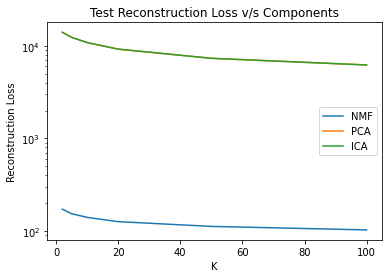

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, loss_test_nmf_list, label = "NMF")
plt.plot(num_latent_space, loss_test_pca_list, label = "PCA")
plt.plot(num_latent_space, loss_test_ica_list, label = "ICA")


path = '../results/Comparison/comparison_test_reconstruction_loss'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Reconstruction Loss')

plt.title('Test Reconstruction Loss v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.yscale('log')


plt.legend()
plt.savefig(path)
plt.show()


Plot Train reconstruction Loss vs num components

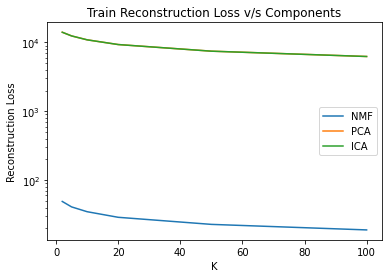

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, loss_train_nmf_list, label = "NMF")
plt.plot(num_latent_space, loss_train_pca_list, label = "PCA")
plt.plot(num_latent_space, loss_train_ica_list, label = "ICA")


path = '../results/Comparison/comparison_train_reconstruction_loss'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Reconstruction Loss')

plt.title('Train Reconstruction Loss v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.yscale('log')


plt.legend()
plt.savefig(path)
plt.show()


Plot SVM accuracy vs num of components

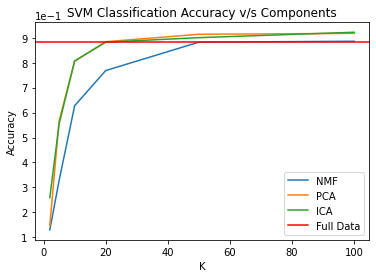

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, accuracy_nmf_svm_list, label = "NMF")
plt.plot(num_latent_space, accuracy_pca_svm_list, label = "PCA")
plt.plot(num_latent_space, accuracy_ica_svm_list, label = "ICA")

plt.axhline(y=accuracy_svm, label = "Full Data", color='red')

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/Comparison/comparison_svm_accuracy'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Accuracy')

plt.title('SVM Classification Accuracy v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()


Plot Logistic Regression accuracy vs num of components

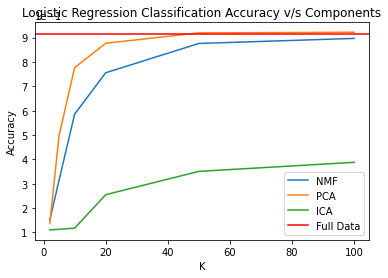

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, accuracy_nmf_lr_list, label = "NMF")
plt.plot(num_latent_space, accuracy_pca_lr_list, label = "PCA")
plt.plot(num_latent_space, accuracy_ica_lr_list, label = "ICA")

plt.axhline(y=accuracy_lr, label = "Full Data", color='red')


path = '../results/Comparison/comparison_lr_accuracy'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Accuracy')

plt.title('Logistic Regression Classification Accuracy v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()


Plot K Means accuracy vs num of components

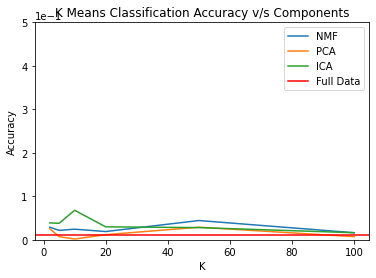

In [ ]:
plt.plot(num_latent_space, accuracy_nmf_km_list, label = "NMF")
plt.plot(num_latent_space, accuracy_pca_km_list, label = "PCA")
plt.plot(num_latent_space, accuracy_ica_km_list, label = "ICA")

plt.axhline(y=accuracy_km, label = "Full Data", color='red')

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/Comparison/comparison_km_accuracy'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Accuracy')

plt.title('K Means Classification Accuracy v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ylim(0,0.5)

plt.legend()
plt.savefig(path)
plt.show()

Plot GMM accuracy vs num of components

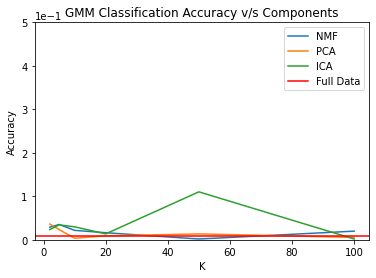

In [ ]:
plt.plot(num_latent_space, accuracy_nmf_gmm_list, label = "NMF")
plt.plot(num_latent_space, accuracy_pca_gmm_list, label = "PCA")
plt.plot(num_latent_space, accuracy_ica_gmm_list, label = "ICA")

plt.axhline(y=accuracy_gmm, label = "Full Data", color='red')


path = '../results/Comparison/comparison_gmm_accuracy'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Accuracy')
plt.ylim(0,0.5)

plt.title('GMM Classification Accuracy v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()

Plot computation time for each of the data compression methods for SVM Classification

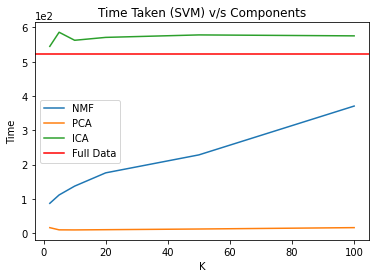

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, time_nmf_svm_list, label = "NMF")
plt.plot(num_latent_space, time_pca_svm_list, label = "PCA")
plt.plot(num_latent_space, time_ica_svm_list, label = "ICA")

plt.axhline(y=time_svm, label = "Full Data", color='red')

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/Comparison/comparison_svm_time'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Time')

plt.title('Time Taken (SVM) v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()


Plot computation time for each of the data compression methods for Logistic Regression

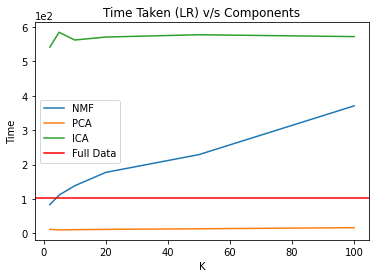

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, time_nmf_lr_list, label = "NMF")
plt.plot(num_latent_space, time_pca_lr_list, label = "PCA")
plt.plot(num_latent_space, time_ica_lr_list, label = "ICA")

plt.axhline(y=time_lr, label = "Full Data", color='red')

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/Comparison/comparison_lr_time'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Time')

plt.title('Time Taken (LR) v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()


Plot computation time for each of the data compression methods for K Means Clustering

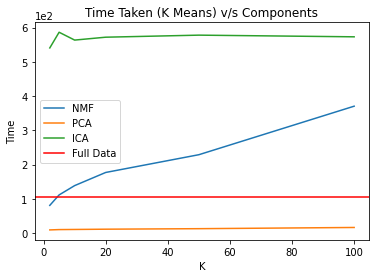

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, time_nmf_km_list, label = "NMF")
plt.plot(num_latent_space, time_pca_km_list, label = "PCA")
plt.plot(num_latent_space, time_ica_km_list, label = "ICA")

plt.axhline(y=time_km, label = "Full Data", color='red')

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/omparison/comparison_km_time'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Time')

plt.title('Time Taken (K Means) v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()


Plot computation time for each of the data compression methods for GMM Clustering

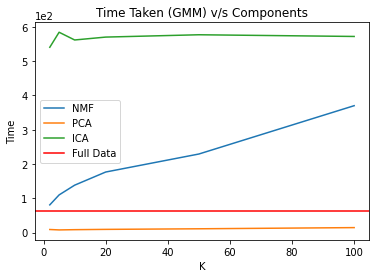

In [ ]:
# plot the different graphs for reconstruction loss

plt.plot(num_latent_space, time_nmf_gmm_list, label = "NMF")
plt.plot(num_latent_space, time_pca_gmm_list, label = "PCA")
plt.plot(num_latent_space, time_ica_gmm_list, label = "ICA")

plt.axhline(y=time_gmm, label = "Full Data", color='red')

# plt.plot(num_latent_space, k_loss_train, label = "Train")

path = '../results/Comparison/comparison_gmm_time'+'.png'


# naming the x axis
plt.xlabel('K')
# naming the y axis
plt.ylabel('Time')

plt.title('Time Taken (GMM) v/s Components')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))


plt.legend()
plt.savefig(path)
plt.show()
